In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
# from torchsummary import summary

# from pushover import notify
# from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
batch_size = 1

In [4]:
dataset = datasets.ImageFolder(root='./data-nodules2d',transform = transforms.Compose([
    transforms.ToTensor()]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
len(dataset.imgs), len(dataloader)

(39274, 39274)

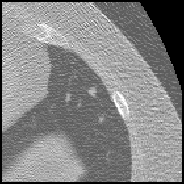

In [5]:
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [ ]:
x = fixed_x[0][0]
x.shape

In [99]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding = 1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1,padding = 1)
        self.fc1 = nn.Linear(64 * 15 * 15, 64)
        self.regression = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64*15*15)
        self.convTrans1 = nn.ConvTranspose2d(64,32,3,1)
        self.conv3 = nn.Conv2d(64,32,3,1,padding = 1)
        self.conv4 = nn.Conv2d(32,1,3,1,padding = 1)
        self.convTrans2 = nn.ConvTranspose2d(32,1,3,1)
    
    def tiling(self, x):
        x = x[0, 0]
        tiled = x.unfold(0,60,60).unfold(1,60,60)
        tiled = tiled.reshape(9, 1, 60, 60)
        return tiled
    
    def untiling(self,x):
        a = torch.cat([x[0],x[1],x[2]],dim = 1)
        b = torch.cat([x[3],x[4],x[5]],dim = 1)
        c = torch.cat([x[6],x[7],x[8]],dim = 1)
        x = torch.cat([a,b,c],dim = 2)
        return x
    
#     def upsample1(self, x):
#         x = self.fc2(x)
#         x = x.reshape(9,-1,56,56)
#         x = self.convTrans1(x)
#         x = F.relu(x)
#         x = self.convTrans2(x)
#         return x
    
    def upsample(self, x):
        x = self.fc2(x)
        x = x.reshape(9,-1,15,15)
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = self.conv3(x)
        x = F.relu(x)
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = self.conv4(x)
        x = torch.sigmoid(x)
        return x

    def downsample(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = x.reshape(9,-1)
        x = self.fc1(x)
        
        return x
    
    def forward(self, x):
        x = self.tiling(x)
        x = self.downsample(x)
        self.Vreconst = x
        I_reconst = self.untiling(self.upsample(x))
        
        Vprime = []
        for i in range(len(x)):
            Vnot_i = self.pool(x, i)
            vprime_i = self.regression(Vnot_i)
            Vprime.append(vprime_i)
        Vprime = torch.cat(Vprime, dim = 0)
        self.Vprime = Vprime
        I_prime = self.untiling(self.upsample(Vprime))

        return I_prime,I_reconst
    
    def pool(self, x, i):
        x = torch.cat((x[0:i], x[i+1:]))
        x = x.mean(0)
        x = x.reshape(1,-1)
        return x

In [100]:
model = Net()
optimizer = optim.Adam(model.parameters())
loss = nn.MSELoss()

In [101]:
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=14400, out_features=64, bias=True)
  (regression): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=14400, bias=True)
  (convTrans1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convTrans2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1))
)

In [126]:
def train(train_loader):
    epoch = 1
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        data = fixed_x
        I_prime,I_reconst = model(data)
        data = data[:, 0]
        l1 = loss(data, I_prime)
        l2 = loss(data, I_reconst)
        (l1+l2).backward()
        optimizer.step()
        
        if batch_idx % 2 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), l1.item(),l2.item()))

train(dataloader)

/Users/shubhamchandel/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Train Epoch: 1 [0/39274 (0%)]	Loss: 0.003929 0.001765
Train Epoch: 1 [2/39274 (0%)]	Loss: 0.003819 0.001723
Train Epoch: 1 [4/39274 (0%)]	Loss: 0.003677 0.001698
Train Epoch: 1 [6/39274 (0%)]	Loss: 0.003680 0.001681
Train Epoch: 1 [8/39274 (0%)]	Loss: 0.003599 0.001647
Train Epoch: 1 [10/39274 (0%)]	Loss: 0.003627 0.001633
Train Epoch: 1 [12/39274 (0%)]	Loss: 0.003507 0.001605
Train Epoch: 1 [14/39274 (0%)]	Loss: 0.003529 0.001589
Train Epoch: 1 [16/39274 (0%)]	Loss: 0.003488 0.001567
Train Epoch: 1 [18/39274 (0%)]	Loss: 0.003435 0.001544
Train Epoch: 1 [20/39274 (0%)]	Loss: 0.003406 0.001526
Train Epoch: 1 [22/39274 (0%)]	Loss: 0.003396 0.001508
Train Epoch: 1 [24/39274 (0%)]	Loss: 0.003486 0.001495
Train Epoch: 1 [26/39274 (0%)]	Loss: 0.003727 0.001485
Train Epoch: 1 [28/39274 (0%)]	Loss: 0.003856 0.001478
Train Epoch: 1 [30/39274 (0%)]	Loss: 0.003297 0.001441
Train Epoch: 1 [32/39274 (0%)]	Loss: 0.003543 0.001437
Train Epoch: 1 [34/39274 (0%)]	Loss: 0.003275 0.001411
Train Epoch: 1 

Train Epoch: 1 [296/39274 (1%)]	Loss: 0.001825 0.000602
Train Epoch: 1 [298/39274 (1%)]	Loss: 0.001905 0.000638
Train Epoch: 1 [300/39274 (1%)]	Loss: 0.001719 0.000628
Train Epoch: 1 [302/39274 (1%)]	Loss: 0.001683 0.000602
Train Epoch: 1 [304/39274 (1%)]	Loss: 0.001654 0.000559
Train Epoch: 1 [306/39274 (1%)]	Loss: 0.001581 0.000563
Train Epoch: 1 [308/39274 (1%)]	Loss: 0.001565 0.000595
Train Epoch: 1 [310/39274 (1%)]	Loss: 0.001541 0.000566
Train Epoch: 1 [312/39274 (1%)]	Loss: 0.001516 0.000524
Train Epoch: 1 [314/39274 (1%)]	Loss: 0.001506 0.000515
Train Epoch: 1 [316/39274 (1%)]	Loss: 0.001497 0.000521
Train Epoch: 1 [318/39274 (1%)]	Loss: 0.001478 0.000515
Train Epoch: 1 [320/39274 (1%)]	Loss: 0.001459 0.000501
Train Epoch: 1 [322/39274 (1%)]	Loss: 0.001451 0.000491
Train Epoch: 1 [324/39274 (1%)]	Loss: 0.001439 0.000486
Train Epoch: 1 [326/39274 (1%)]	Loss: 0.001421 0.000480
Train Epoch: 1 [328/39274 (1%)]	Loss: 0.001409 0.000476
Train Epoch: 1 [330/39274 (1%)]	Loss: 0.001399 0

Train Epoch: 1 [590/39274 (2%)]	Loss: 0.000788 0.000256
Train Epoch: 1 [592/39274 (2%)]	Loss: 0.000923 0.000289
Train Epoch: 1 [594/39274 (2%)]	Loss: 0.000768 0.000252
Train Epoch: 1 [596/39274 (2%)]	Loss: 0.000850 0.000267
Train Epoch: 1 [598/39274 (2%)]	Loss: 0.000748 0.000249
Train Epoch: 1 [600/39274 (2%)]	Loss: 0.000817 0.000258
Train Epoch: 1 [602/39274 (2%)]	Loss: 0.000732 0.000244
Train Epoch: 1 [604/39274 (2%)]	Loss: 0.000777 0.000255
Train Epoch: 1 [606/39274 (2%)]	Loss: 0.000720 0.000242
Train Epoch: 1 [608/39274 (2%)]	Loss: 0.000748 0.000251
Train Epoch: 1 [610/39274 (2%)]	Loss: 0.000707 0.000240
Train Epoch: 1 [612/39274 (2%)]	Loss: 0.000731 0.000240
Train Epoch: 1 [614/39274 (2%)]	Loss: 0.000701 0.000238
Train Epoch: 1 [616/39274 (2%)]	Loss: 0.000708 0.000237
Train Epoch: 1 [618/39274 (2%)]	Loss: 0.000700 0.000237
Train Epoch: 1 [620/39274 (2%)]	Loss: 0.000693 0.000235
Train Epoch: 1 [622/39274 (2%)]	Loss: 0.000712 0.000237
Train Epoch: 1 [624/39274 (2%)]	Loss: 0.000729 0

Train Epoch: 1 [884/39274 (2%)]	Loss: 0.000532 0.000420
Train Epoch: 1 [886/39274 (2%)]	Loss: 0.000536 0.000366
Train Epoch: 1 [888/39274 (2%)]	Loss: 0.000515 0.000293
Train Epoch: 1 [890/39274 (2%)]	Loss: 0.000494 0.000228
Train Epoch: 1 [892/39274 (2%)]	Loss: 0.000487 0.000186
Train Epoch: 1 [894/39274 (2%)]	Loss: 0.000491 0.000167
Train Epoch: 1 [896/39274 (2%)]	Loss: 0.000474 0.000164
Train Epoch: 1 [898/39274 (2%)]	Loss: 0.000456 0.000166
Train Epoch: 1 [900/39274 (2%)]	Loss: 0.000439 0.000169
Train Epoch: 1 [902/39274 (2%)]	Loss: 0.000441 0.000167
Train Epoch: 1 [904/39274 (2%)]	Loss: 0.000450 0.000163
Train Epoch: 1 [906/39274 (2%)]	Loss: 0.000443 0.000161
Train Epoch: 1 [908/39274 (2%)]	Loss: 0.000431 0.000159
Train Epoch: 1 [910/39274 (2%)]	Loss: 0.000421 0.000156
Train Epoch: 1 [912/39274 (2%)]	Loss: 0.000419 0.000154
Train Epoch: 1 [914/39274 (2%)]	Loss: 0.000420 0.000151
Train Epoch: 1 [916/39274 (2%)]	Loss: 0.000417 0.000150
Train Epoch: 1 [918/39274 (2%)]	Loss: 0.000412 0

KeyboardInterrupt: 

In [127]:
fixed_x.shape

torch.Size([1, 3, 180, 180])

In [128]:
Ipr,Ire = model(fixed_x)
Ire.shape

/Users/shubhamchandel/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


torch.Size([1, 180, 180])

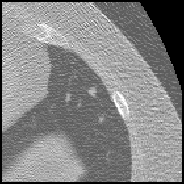

In [129]:
save_image(fixed_x, 'real_image.png')
Image('real_image.png')

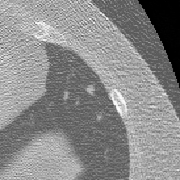

In [130]:
save_image(Ipr, 'real_image.png')
Image('real_image.png')

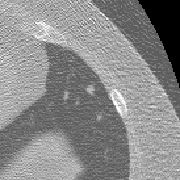

In [131]:
save_image(Ire, 'real_image.png')
Image('real_image.png')

In [134]:
torch.matmul(model.Vprime, model.Vreconst.T).long()

tensor([[ 106,   35,  -21,   40,   47,  -37,  -50,  -32,   69],
        [  44,   66,  -48,   23,   41,  -20,   25,   10,   37],
        [   4,  -17,   75,   13,   74,  -17,    0,    3,   59],
        [  70,   39,    1,  136,   37,  -29, -131,   45,   53],
        [  36,   -2,  -10,   -3,  110,  -24,  -13,  -61,   59],
        [  14,   24,   -6,    0,   43,    0,   50,   11,   25],
        [ -20,   16,  -34, -148,   56,  -13,  261,   -8,   21],
        [   7,   21,   14,   26,   29,  -22,   59,   81,   27],
        [  55,   27,  -23,   12,   69,  -35,    0,  -29,   74]])